### Read start_date and track_length from SMDB for all Missions and plot them over time

In [1]:
import json
import pandas as pd
import requests

# Get Mission data from smdb.shore.mbari.org's graphql REST api and put into dataframe

query = """query MyQuery {
  all_missions {
    name
    start_date
    track_length
  }
}"""
smdb_url = "https://smdb.shore.mbari.org"
response = requests.post(f"{smdb_url}/graphql", json={'query': query})
data = json.loads(response.text)
df = pd.json_normalize(data['data'], record_path=["all_missions"])
df["date"] = df["start_date"].astype("datetime64[ns]")
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
print(f"Number of Missions: {len(df)}")
df.dropna(inplace=True)
print(f"Number of Missions with navtracks and track_length: {len(df)}")
df

Number of Missions: 808
Number of Missions with navtracks and track_length: 771


,name,start_date,track_length
date,,,
2005-09-06 04:30:32.000000,MappingAUVOps2010/200509EndeavourABE,2005-09-06T04:30:32,209.3649
2006-02-21 18:12:04.874998,MappingAUVOps2006/20060221,2006-02-21T18:12:04.874998,9.6957
2006-02-22 17:49:57.625999,MappingAUVOps2006/20060222,2006-02-22T17:49:57.625999,10.8014
2006-03-21 23:43:20.441999,MappingAUVOps2006/20060321,2006-03-21T23:43:20.441999,1.1191
2006-03-22 18:08:03.718999,MappingAUVOps2006/20060322,2006-03-22T18:08:03.718999,15.3460
...,...,...,...
2022-01-26 17:24:00.171170,2022/20220126m2,2022-01-26T17:24:00.171170,7.4010
2022-01-26 18:40:15.110795,2022/20220126m3,2022-01-26T18:40:15.110795,0.9708
2022-01-26 19:04:43.244678,2022/20220126m4,2022-01-26T19:04:43.244678,7.3701


In [2]:
from os.path import basename, dirname

def remove_duplicate_tracks(df: pd.DataFrame) -> pd.DataFrame:
    # Missions with names like 2021/20210910d1/lidar and 2021/20210910d1/multibeam
    # have the same nav_track and shouldn't be counted twice, remove the duplicate
    row_dict = {}
    for _, row in df.iterrows():
        leaf_dir = basename(row['name'])
        if leaf_dir.lower() == 'multibeam' or leaf_dir == 'lidar':
            # print(f"Renaming {row['name']} to {dirname(row['name'])}")
            row_dict[dirname(row['name'])] = ((row['start_date'], row['track_length']))
        else:
            row_dict[row['name']] = ((row['start_date'], row['track_length'], ))
    row_list = []
    for key, value in row_dict.items():
        row_list.append({'name': key, 'start_date': value[0], 'track_length': value[1]})

    df_new = pd.DataFrame(row_list, columns=['name', 'start_date', 'track_length'])
    df_new["date"] = df_new["start_date"].astype("datetime64[ns]")
    df_new.set_index('date', inplace=True)
    df_new.drop('start_date', axis=1, inplace=True)
    df_new.sort_index(inplace=True)
    # Remove duplicated date indexes: https://stackoverflow.com/a/34297689/1281657
    df_new = df_new[~df_new.index.duplicated(keep='first')]
    df_new['track_length_cum_sum'] = df_new['track_length'].cumsum()

    return df_new

df = remove_duplicate_tracks(df)
print(f"Number of Missions after removing duplicate multibeam/lidar tracks: {len(df)}")
df

Number of Missions after removing duplicate multibeam/lidar tracks: 717


,name,track_length,track_length_cum_sum
date,,,
2005-09-06 04:30:32.000000,MappingAUVOps2010/200509EndeavourABE,209.3649,209.3649
2006-02-21 18:12:04.874998,MappingAUVOps2006/20060221,9.6957,219.0606
2006-02-22 17:49:57.625999,MappingAUVOps2006/20060222,10.8014,229.8620
2006-03-21 23:43:20.441999,MappingAUVOps2006/20060321,1.1191,230.9811
2006-03-22 18:08:03.718999,MappingAUVOps2006/20060322,15.3460,246.3271
...,...,...,...
2022-01-26 17:24:00.171170,2022/20220126m2,7.4010,28691.6636
2022-01-26 18:40:15.110795,2022/20220126m3,0.9708,28692.6344
2022-01-26 19:04:43.244678,2022/20220126m4,7.3701,28700.0045


In [3]:
# List and remove non-MBARI and test Missions
df_non_mbari = df[df["name"].str.contains("ABE|sentry|test")]
df = df[~df["name"].str.contains("ABE|sentry|test")]
pd.set_option('max_colwidth', 400)
print(f"Removing these {len(df_non_mbari)} non-MBARI and test Missions:")
df_non_mbari

Removing these 33 non-MBARI and test Missions:


,name,track_length,track_length_cum_sum
date,,,
2005-09-06 04:30:32.000000,MappingAUVOps2010/200509EndeavourABE,209.3649,209.3649
2008-08-03 11:15:43.236999,MappingAUVOps2008/sentry016,8.7955,2522.6467
2013-03-18 18:47:28.066610,MappingAUVOps2013/TN293_Moyer13/sentry165/sentry165-proc,15.6141,10121.4455
2013-03-19 22:43:20.002059,MappingAUVOps2013/TN293_Moyer13/sentry166/sentry166-proc,46.0588,10167.5043
2013-03-21 19:09:09.816666,MappingAUVOps2013/TN293_Moyer13/sentry167/sentry167-proc,15.4296,10182.9339
2013-03-22 20:30:00.316741,MappingAUVOps2013/TN293_Moyer13/sentry168/sentry168-proc,46.0399,10228.9738
2013-03-25 10:56:42.316711,MappingAUVOps2013/TN293_Moyer13/sentry169/sentry169-proc,11.4712,10240.4450
2013-03-26 11:15:00.066783,MappingAUVOps2013/TN293_Moyer13/sentry171/sentry171-proc,30.7469,10271.1919
2014-06-27 19:33:48.063976,MappingAUVOps2014/Sentry_Loihi/2014-glazer/dives/sentry264/multibeam/mbari,12.2702,12523.9298


In [4]:
# Check for outlier track_lengths
df_sorted = df[["name", "track_length"]].sort_values(by=['track_length'], ascending=False)
df_sorted.head(20)

,name,track_length
date,,
2013-09-29 00:11:38.219001,MappingAUVOps2013/20130928m1,1003.9967
2018-04-25 12:05:15.352999,MappingAUVOps2018/20180425m2,112.8497
2018-04-27 20:23:46.791000,MappingAUVOps2018/20180427m2,110.4419
2018-05-10 04:35:32.775001,MappingAUVOps2018/20180509m2,110.3396
2018-05-09 00:44:57.913002,MappingAUVOps2018/20180508m2,109.9836
2018-05-07 12:28:36.025001,MappingAUVOps2018/20180507m1,108.7400
2018-04-26 16:34:51.222000,MappingAUVOps2018/20180426m2,108.2758
2018-05-05 00:12:59.469001,MappingAUVOps2018/20180504m2,107.8197
2018-04-30 15:44:01.053999,MappingAUVOps2018/20180430m1,106.9375


In [5]:
# Keep Missions with track_lengths < 300 km and re-compute track_length_cum_sum
df = df[df['track_length'] < 300]
df['track_length_cum_sum'] = df['track_length'].cumsum()
df

,name,track_length,track_length_cum_sum
date,,,
2006-02-21 18:12:04.874998,MappingAUVOps2006/20060221,9.6957,9.6957
2006-02-22 17:49:57.625999,MappingAUVOps2006/20060222,10.8014,20.4971
2006-03-21 23:43:20.441999,MappingAUVOps2006/20060321,1.1191,21.6162
2006-03-22 18:08:03.718999,MappingAUVOps2006/20060322,15.3460,36.9622
2006-04-19 21:12:06.272999,MappingAUVOps2006/20060419,3.7344,40.6966
...,...,...,...
2022-01-26 17:24:00.171170,2022/20220126m2,7.4010,26659.2107
2022-01-26 18:40:15.110795,2022/20220126m3,0.9708,26660.1815
2022-01-26 19:04:43.244678,2022/20220126m4,7.3701,26667.5516


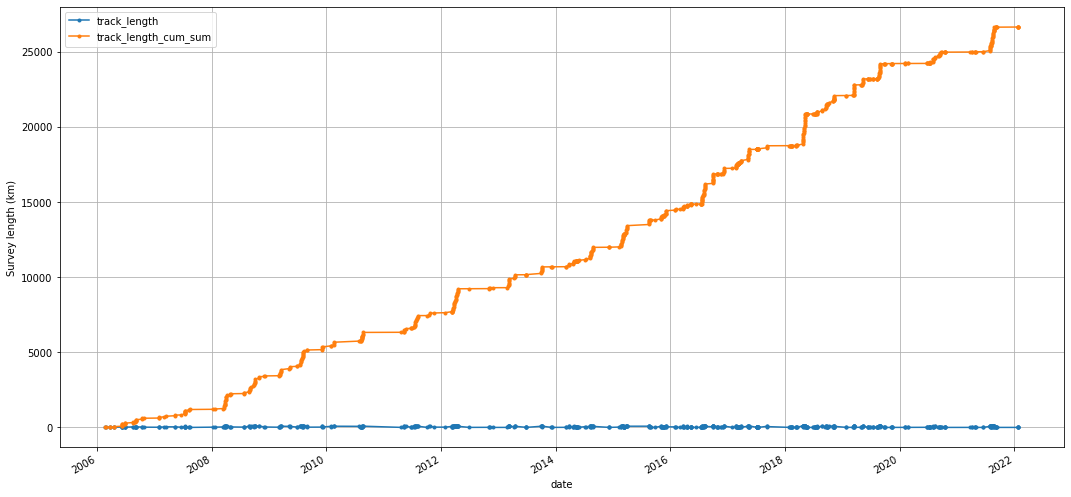

In [6]:
# Plot and export to csv
df.plot(ylabel="Survey length (km)", marker=".", figsize=(18,9), grid=True)
df.to_csv("smdb_track_lengths.csv")